<a href="https://colab.research.google.com/github/matheusro/Uniritter-topicos2-NLP/blob/master/Trabalho_Topicos_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trabalho Prático - Processamento de Linguagem Natural
Disciplina: Tópicos II / Professor: William Becker

### Alunos:
Gustavo da Costa Oliveira / Vinícius Valim de Melo / Cláudia Duarte Rodrigues de Oliveira / Matheus Reck de Oliveira

Fonte do Dataset: https://www.kaggle.com/cursostic/avaliao-atendimento#all.csv

Os dados analisados contêm **avaliações de atendimento de equipe de Suporte de TI**.

In [0]:
import numpy as np
import pandas as pd
dataset = pd.read_excel("all.xlsx")

In [67]:
print(dataset)

                                                  coment manifest_atendimento
0                              Nunca abri esse incidente               neutro
1      Profissionais educados, atenciosos e o mais im...               elogio
2      Não tenho condições de responder a esta pesqui...           reclamação
3      Chamado não foi resolvido. Apesar de explicado...           reclamação
4      O chamado foi encerrado como concluído. Porém,...           reclamação
...                                                  ...                  ...
42309  O problema não foi resolvido, porém foi fornec...               neutro
42310                            Excelente atendimento!!               elogio
42311                              Atendimento perfeito.               elogio
42312  Não foi resolvido por motivos externos, servid...               neutro
42313                   Serviço com atendimento perfeito               elogio

[42314 rows x 2 columns]


Ao descrever o dataset abaixo, percebe-se que existem algumas avaliações de atendimento onde os usuários não fizeram nenhum comentário **(8 casos)**.

Coincidentemente, alguns usuários incluiram exatamente os mesmos comentários na avaliação. No entanto, ainda temos muitos comentários exclusivos, **totalizando 31253**.

O comentário mais reincidente foi o elogio de **"Excelente atendimento."**, sendo apresentado **634 vezes**.

In [68]:
print(dataset.describe()) 

                        coment manifest_atendimento
count                    42306                42314
unique                   31253                    3
top     Excelente atendimento.               elogio
freq                       634                27630


Como primeiro ajuste do dataset, removemos os registros que não tiveram nenhum comentário.

In [0]:
# remove os comentarios nulos
dataset = dataset[dataset["coment"].isnull() == False]

In [70]:
print(dataset.describe()) 

                        coment manifest_atendimento
count                    42306                42306
unique                   31253                    3
top     Excelente atendimento.               elogio
freq                       634                27630


Analisando as classes originais do dataset, temos a seguinte distribuição:

In [71]:
print(dataset['manifest_atendimento'].value_counts())

elogio        27630
neutro         8174
reclamação     6502
Name: manifest_atendimento, dtype: int64


Para simplificar o modelo, vamos trabalhar somente com duas categorias (elogio e reclamação). Neste caso, iremos considerar que todas avaliações neutras também são reclamação.

In [0]:
# considera todas avaliações neutras como reclamação para equilibrar a amostragem entre 'elogio' X 'reclamação'
dataset.loc[dataset.manifest_atendimento == 'neutro', 'manifest_atendimento'] = 'reclamação'

In [73]:
print(dataset['manifest_atendimento'].value_counts())

elogio        27630
reclamação    14676
Name: manifest_atendimento, dtype: int64


Abaixo, nós convertemos os tipos de dado dos campos 'coment' para 'str' e 'manifest_atendimento' para 'category'.

In [0]:
# converte os comentarios para string
dataset['coment'] = dataset.coment.astype(str)
# converte os manifestos para categorico
dataset['manifest_atendimento'] = dataset.manifest_atendimento.astype('category')

A seguir, iniciamos alguns tratamentos específicos do campo 'coment', como por exemplo a tokenização e a limpeza de caracteres especiais.

In [0]:
def removerAcentosECaracteresEspeciais(palavra):

    # Unicode normalize transforma um caracter em seu equivalente em latin.
    nfkd = unicodedata.normalize('NFKD', palavra)
    palavraSemAcento = u"".join([c for c in nfkd if not unicodedata.combining(c)])

    # Usa expressão regular para retornar a palavra apenas com números, letras e espaço
    return re.sub('[^a-zA-Z0-9 \\\]', '', palavraSemAcento)

In [76]:
import nltk
import unicodedata
import re
# importa tokenizadores e stopwords
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [0]:
# realiza a limpeza nos dados (lowercase e remocao de caracteres)
replace_espaco = re.compile('[/(){}\[\]\|@,;]')

def pre_processamento(text):
    text = text.lower()
    text = replace_espaco.sub(' ', text)
    return text

dataset['coment'] = dataset['coment'].apply(pre_processamento)
dataset['coment'] = dataset['coment'].apply(removerAcentosECaracteresEspeciais)

In [78]:
print(dataset)

                                                  coment manifest_atendimento
0                              nunca abri esse incidente           reclamação
1      profissionais educados  atenciosos e o mais im...               elogio
2      nao tenho condicoes de responder a esta pesqui...           reclamação
3      chamado nao foi resolvido apesar de explicado ...           reclamação
4      o chamado foi encerrado como concluido porem  ...           reclamação
...                                                  ...                  ...
42309  o problema nao foi resolvido  porem foi fornec...           reclamação
42310                              excelente atendimento               elogio
42311                               atendimento perfeito               elogio
42312  nao foi resolvido por motivos externos  servid...           reclamação
42313                   servico com atendimento perfeito               elogio

[42306 rows x 2 columns]


**Tokenização** de cada um dos comentários:

In [79]:
# preparacao dos dados
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# tokenizando as sentencas
dataset["coment"] = [word_tokenize(word) for word in dataset["coment"]]
print(dataset)

                                                  coment manifest_atendimento
0                         [nunca, abri, esse, incidente]           reclamação
1      [profissionais, educados, atenciosos, e, o, ma...               elogio
2      [nao, tenho, condicoes, de, responder, a, esta...           reclamação
3      [chamado, nao, foi, resolvido, apesar, de, exp...           reclamação
4      [o, chamado, foi, encerrado, como, concluido, ...           reclamação
...                                                  ...                  ...
42309  [o, problema, nao, foi, resolvido, porem, foi,...           reclamação
42310                           [excelente, atendimento]               elogio
42311                            [atendimento, perfeito]               elogio
42312  [nao, foi, resolvido, por, motivos, externos, ...           reclamação
42313              [servico, com, atendimento, perfeito]               elogio

[42306 rows x 2 columns]


Aplicamos em seguida a remoção de **stopwords** da língua portuguesa e **stemming** sobre as palavras para obtenção dos radicais, guardando-as no campo **'coment_stem'**:

In [0]:
# remocao de stopwords
dataset["coment"] = dataset["coment"].apply(lambda x: [item for item in x if item not in stopwords.words("portuguese")])

In [81]:
print(dataset)

                                                  coment manifest_atendimento
0                               [nunca, abri, incidente]           reclamação
1      [profissionais, educados, atenciosos, importan...               elogio
2      [nao, condicoes, responder, pesquisa, onde, pa...           reclamação
3      [chamado, nao, resolvido, apesar, explicado, n...           reclamação
4      [chamado, encerrado, concluido, porem, ramal, ...           reclamação
...                                                  ...                  ...
42309  [problema, nao, resolvido, porem, fornecido, o...           reclamação
42310                           [excelente, atendimento]               elogio
42311                            [atendimento, perfeito]               elogio
42312  [nao, resolvido, motivos, externos, servidor, ...           reclamação
42313                   [servico, atendimento, perfeito]               elogio

[42306 rows x 2 columns]


In [82]:
# Tratar as palavras para obter somente radicais - STEMMING
import nltk
nltk.download('rslp')
from nltk.stem import RSLPStemmer

def Stemming(sentence):
    stemmer = RSLPStemmer()
    phrase = []
    for word in sentence:
        phrase.append(stemmer.stem(word.lower()))
    return phrase

[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Package rslp is already up-to-date!


In [83]:
# Cria coluna nova com os radicais das palavras
dataset['coment_stem'] = dataset['coment'].apply(Stemming)
print(dataset)

                                                  coment  ...                                        coment_stem
0                               [nunca, abri, incidente]  ...                                 [nunc, abr, incid]
1      [profissionais, educados, atenciosos, importan...  ...  [profiss, educ, atenci, import, problem, resol...
2      [nao, condicoes, responder, pesquisa, onde, pa...  ...  [nao, condico, respond, pesquis, ond, parec, p...
3      [chamado, nao, resolvido, apesar, explicado, n...  ...  [cham, nao, resolv, apes, explic, necess, priv...
4      [chamado, encerrado, concluido, porem, ramal, ...  ...  [cham, encerr, conclu, por, ramal, continu, co...
...                                                  ...  ...                                                ...
42309  [problema, nao, resolvido, porem, fornecido, o...  ...  [problem, nao, resolv, por, fornec, orientaco,...
42310                           [excelente, atendimento]  ...                                   

In [84]:
dataset["coment"] = [' '.join(word) for word in dataset["coment"]]
dataset["coment_stem"] = [' '.join(word) for word in dataset["coment_stem"]]
print(dataset)

                                                  coment  ...                                        coment_stem
0                                   nunca abri incidente  ...                                     nunc abr incid
1      profissionais educados atenciosos importante p...  ...  profiss educ atenci import problem resolv prof...
2      nao condicoes responder pesquisa onde parecer ...  ...  nao condico respond pesquis ond parec promet a...
3      chamado nao resolvido apesar explicado necessi...  ...  cham nao resolv apes explic necess privilegi a...
4      chamado encerrado concluido porem ramal contin...  ...  cham encerr conclu por ramal continu const con...
...                                                  ...  ...                                                ...
42309  problema nao resolvido porem fornecido orienta...  ...  problem nao resolv por fornec orientaco necess...
42310                              excelente atendimento  ...                                   

A seguir é apresentado um ranking das palavras mais frequentes nos comentários, onde percebemos que a mais mencionada foi **'atendimento'**, sendo exibida **17513 vezes**.

In [0]:
counts = dict()
for i in range(0, len(dataset)):
    texto = dataset.iloc[i]['coment']
    words = texto.split()
    for word in words:
        if word in counts:
            counts[word] += 1
        else:
            counts[word] = 1

In [86]:
sorted(counts.items(), key=lambda x: x[1], reverse=True)

[('atendimento', 17513),
 ('nao', 9102),
 ('excelente', 6903),
 ('problema', 5794),
 ('atendente', 3991),
 ('rapido', 3221),
 ('otimo', 3156),
 ('parabens', 3051),
 ('chamado', 2825),
 ('bom', 2656),
 ('resolvido', 2641),
 ('eficiente', 2285),
 ('obrigado', 1845),
 ('atendido', 1740),
 ('tecnico', 1675),
 ('solicitacao', 1656),
 ('solucao', 1606),
 ('bem', 1560),
 ('servico', 1559),
 ('tic', 1387),
 ('ser', 1384),
 ('equipe', 1321),
 ('resolver', 1212),
 ('trabalho', 1177),
 ('pois', 1124),
 ('tempo', 1109),
 ('acesso', 1072),
 ('obrigada', 1016),
 ('ainda', 979),
 ('local', 978),
 ('profissional', 978),
 ('atencioso', 952),
 ('ja', 947),
 ('presteza', 929),
 ('sistema', 879),
 ('sempre', 874),
 ('eficiencia', 864),
 ('rapidez', 832),
 ('atendeu', 815),
 ('apoio', 813),
 ('contato', 803),
 ('eficaz', 799),
 ('resolveu', 798),
 ('atendida', 797),
 ('agradeco', 787),
 ('dia', 778),
 ('porem', 775),
 ('nota', 765),
 ('ter', 760),
 ('so', 736),
 ('satisfeito', 736),
 ('agilidade', 719),
 (

In [87]:
#distribuição de frequencia das palavras/frases
from nltk.probability import FreqDist
frequencia = FreqDist(dataset['coment_stem'])
frequencia

FreqDist({'nunc abr incid': 1,
          'profiss educ atenci import problem resolv profiss envolv parab obrig': 1,
          'nao condico respond pesquis ond parec promet are tecn explic soluca dad ate moment apen provis element aqu apresent avaliaca so pod ser nega reynald tayl': 1,
          'cham nao resolv apes explic necess privilegi administr notebook dev fat trabalh gerenc tecn prest suport are automaca atend nao conced privilegi': 1,
          'cham encerr conclu por ramal continu const cont telefon ce': 1,
          'dem soluca problem': 3,
          'dem relativ alt resoluca sistem vital': 1,
          'inform skyp nao pod ser instal desktop': 1,
          'aguard parec gerent unidad': 1,
          'principi resolv so cert me vem vi corret': 1,
          'excel atend tecn ricard nogu erb': 1,
          'conclu cham verific problem resolv acab chec permanec soluca': 1,
          'microcomput mes corporat mi00206088 nao retir chav mo18 const dsp marc 15 gerenc uoe prdc prdct':

Para entender melhor a distribuição das palavras frequentes, geramos duas visões de nuvem de palavras, sendo a primeira dos 'elogios' e a segunda das 'reclamações'.

In [0]:
#pip install wordcloud
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 

In [0]:
def nuvem_palavras(dataset):

    comment_words = ''  
    stopwords = set(STOPWORDS)

    for i in range(0, len(dataset)):
        val = dataset.iloc[i]['coment']
        tokens = val.split() 
      
        for i in range(len(tokens)): 
            tokens[i] = tokens[i].lower() 
              
        for words in tokens: 
            comment_words = comment_words + words + ' '

    wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 

    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
      
    plt.show() 

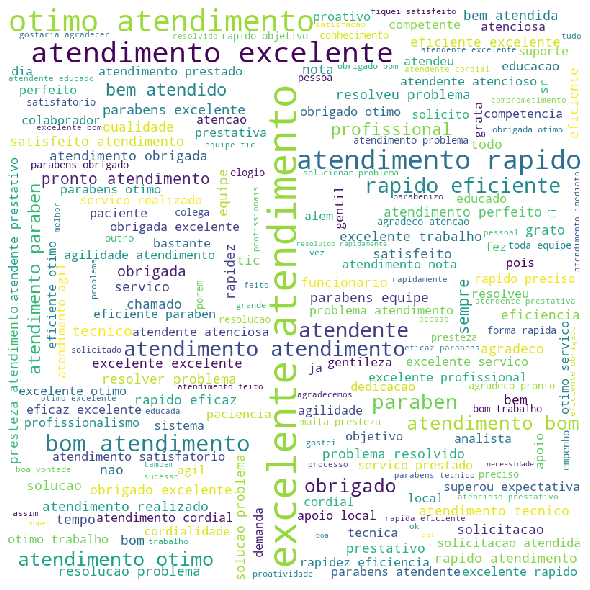

In [90]:
elogios = dataset[dataset['manifest_atendimento']=='elogio']
nuvem_palavras(elogios)

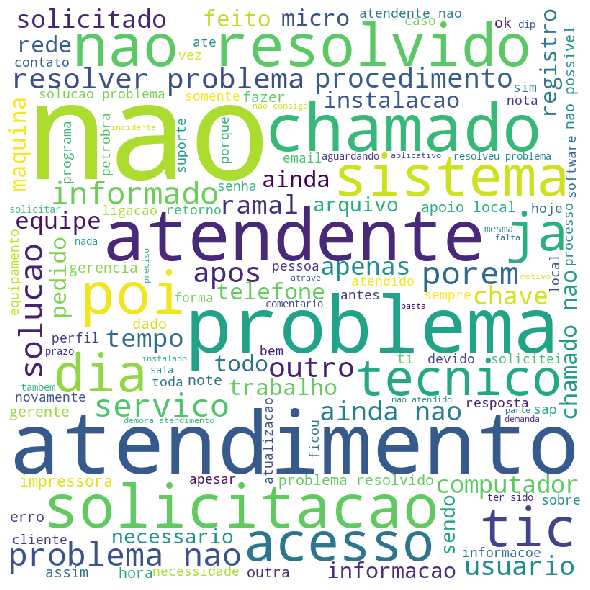

In [91]:
reclamacoes = dataset[dataset['manifest_atendimento']=='reclamação']
nuvem_palavras(reclamacoes)

In [92]:
dataset.coment_stem

0                                           nunc abr incid
1        profiss educ atenci import problem resolv prof...
2        nao condico respond pesquis ond parec promet a...
3        cham nao resolv apes explic necess privilegi a...
4        cham encerr conclu por ramal continu const con...
                               ...                        
42309    problem nao resolv por fornec orientaco necess...
42310                                          excel atend
42311                                        atend perfeit
42312                  nao resolv motiv extern serv inoper
42313                                   serv atend perfeit
Name: coment_stem, Length: 42306, dtype: object

Após as análises e preparação dos dados, começamos a treinar nossos modelos.

In [0]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(dataset["coment_stem"], 
                                                                    dataset["manifest_atendimento"], 
                                                                    test_size=0.3)

In [0]:
from sklearn.preprocessing import LabelEncoder

Encoder = LabelEncoder()
y_train = Encoder.fit_transform(y_train)
y_test = Encoder.fit_transform(y_test)

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer

Tfidf_vect = TfidfVectorizer(max_features=5000)
Tfidf_vect.fit(dataset["coment_stem"])
Train_X_Tfidf = Tfidf_vect.transform(X_train)
Test_X_Tfidf = Tfidf_vect.transform(X_test)

In [0]:
from sklearn import naive_bayes
from sklearn.metrics import accuracy_score

Naive = naive_bayes.MultinomialNB()
Naive.fit(Train_X_Tfidf, y_train)

predictions = Naive.predict(Test_X_Tfidf)

In [97]:
print("Acuracia NB:", accuracy_score(predictions, y_test)*100)

Acuracia NB: 92.31799558777183


In [0]:
# Aplicar o SVM

In [0]:
# INCLUIR UM TESTE DO MODELO 
## Inventar um ELOGIO e um RECLAMAÇÃO